In [104]:
import requests
import csv
import time
from collections import Counter
import pandas as pd
import datetime as dt #only if you want to analyze the date created feature
import json 
from types import SimpleNamespace
import sys
from nltk.tokenize import TreebankWordTokenizer
from textblob import TextBlob
from tabulate import tabulate
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import importlib

import featurization
importlib.reload(featurization)
from featurization import *

import tryutils
importlib.reload(tryutils)
from tryutils import *

### Notes @ Prerna, @ Paras

#### Overleaf Material 
I've tried to add notes in every cell. 

I've mentioned the statistics for the new cleaned - processed for nulls etc. dataset (with equal number of training examples) below.


#### Github Notes:

1. Download ZIP from https://github.com/MallikaKhullar/CS224u-project
2. Extract it and make it a folder
3. `cd` into the folder in terminal:

`git pull`  (will fetch all the newest changes)

4. `conda activate nlu_project` (or whatever your conda environment for this class is)
5. `jupyter notebook`
6. Open this notebook
7. You can modify this notebook (but ideally make a copy of this and run on your own)
8. Once you're done with your changes: in terminal: 

`git add .`

`git commit -m "Commit message here"`

`git push`


#### Bigrams, Characters - Needs to be checked and run over the large dataset
Can you guys run the cells up to the bigrams and character tokens? I'm not sure of the expected values, can you confirm they're correct?
Currently: I see bigrams as a list of words and character-tokens as [5] or [4] etc.

#### Running time
It's taking a looooong time to run the featurization on a dataframe of 3000 rows. If we try to run it on the full dataset, it might take a long time. Could somebody else also run it on their system?


### Reading the dataset

Two Main dataframes
1. One for the anxious-group users (those self-proclaimed as depressed)
2. One for the control group users (those not self-proclaimed as depressed)

Within the Anxious-users group, three smaller dataframes:
1. One for posts in any mental health forum
2. One for posts in the anxiety forum
3. One for posts in unrelated forums (r/Advice, r/AskReddit etc.)

Clearly defining the group / subreddits types:

1. ANXG_ANXIETY (anxiety-sufferers, anxiety subreddits)
2. ANXG_MENTAL (anxiety-sufferers, mental illness related subreddits)
3. ANXG_UNRELATED (anxiety-sufferers, unrelated subreddits)
4. CONTROLG_UNRELATED (non anxiety-sufferers, unrelated subreddits)

In [284]:
# READ THE CSVs
df_anx_1_raw = pd.read_csv("dataset-v1/reddit-posts-mental.csv", index_col=0)
df_anx_2_raw = pd.read_csv("dataset-v1/reddit-posts-anxiety.csv", index_col=0)
df_anx_3_raw = pd.read_csv("dataset-v1/reddit-posts-unrelated.csv", index_col=0)
df_control_group_raw_big = pd.read_csv("dataset-v1/reddit-control.csv", index_col=0)
df_control_group_raw = df_control_group_big.head(df_anx_2_raw.shape[0]).copy()

### Cleaning the JSON 

In [285]:
# MAKE SURE THEY HAVE A LABEL
def clean_df(df_data, label):
    df_data['text'] = df_data['title'] + df_data['body']
    df_data['label'] = label
    df_data = df_data.dropna()
    return df_data[['num_u', 'num_c', 'text', 'label']].copy()

df_anx_1 = clean_df(df_anx_1_raw, 1)
df_anx_2 = clean_df(df_anx_2_raw, 1)
df_anx_3 = clean_df(df_anx_3_raw, 1)
df_control_group = clean_df(df_control_group_raw, 0)
df_anxiety_group = pd.concat([df_anx_1, df_anx_2, df_anx_3])

# COMBINE ALL POSTS INTO A MASTER DATAFRAME (TRAINING DATA)
df_data = pd.concat([df_anxiety_group, df_control_group])
df_data = df_data.sample(frac=1) 

### Data statistics

In [251]:
print("Initial Sample size of Unique users for the Anxiety Group: 14,299\n(no restriction on how many posts they have etc.)\n")

def print_data_size(df, group):
    print("*Original {} size:\t".format(group), df.shape[0])
    print("*Size after dropping nulls:\t", df.dropna().shape[0], "\n")

bprint("Anxiety group posts:\n")

print_data_size(df_anx_1, "ANXG_MENTAL")
print_data_size(df_anx_2, "ANXG_ANXIETY")
print_data_size(df_anx_3, "ANXG_UNRELATED")

bprint("-----------\n\nAnxiety Group vs. Control Group:\n")

print_data_size(df_anxiety_group, "Anxiety-Group")
print_data_size(df_control_group, "Control-Group")

Initial Sample size of Unique users for the Anxiety Group: 14,299
(no restriction on how many posts they have etc.)

Anxiety group posts:

*Original ANXG_MENTAL size:	 1377
*Size after dropping nulls:	 1377 

*Original ANXG_ANXIETY size:	 4786
*Size after dropping nulls:	 4786 

*Original ANXG_UNRELATED size:	 4786
*Size after dropping nulls:	 4786 

-----------

Anxiety Group vs. Control Group:

*Original Anxiety-Group size:	 10949
*Size after dropping nulls:	 10949 

*Original Control-Group size:	 4786
*Size after dropping nulls:	 4786 



### Featurize the dataset

In [204]:
# Initialize dictionary for features (don't need to do this more than once)
age_dict, gender_dict, category_dict, perma_dict = init_perma_age_gender()

In [252]:
import featurization
importlib.reload(featurization)
from featurization import *

def featurize_age(df, dicti):
    df['age'] = [get_age(text, dicti) for text in df['text']]
    print("\nAge featurization - done")

def featurize_gender(df, dicti):
    df['gender'] = [get_gender(text, dicti) for text in df['text']]
    print("\nGender featurization - done")
    
def featurize_perma(df, dicti, category_dict):
    for category in category_dict:
        df[category] = [get_perma(text, category, dicti) for text in df['text']]
    print("\nPerma featurization - done")
    
def featurize_bigrams(df):
    df['bigrams'] = [get_bigrams(str(text)) for text in df['text']]
    print("\nBigrams featurization - done")
    
def featurize_char_tokens(df):
    tokenizer = init_char_tokenizer(df)
    df['char_tokens'] = [get_char_tokens(str(text), tokenizer) for text in df['text']]
    print("\nChar featurization - done")
    
def featurize(df):
    bprint("Featurizing df shape: {}".format(df.shape))
    featurize_age(df, age_dict)
    featurize_gender(df, gender_dict)
    featurize_perma(df, perma_dict, category_dict)
    featurize_bigrams(df)
    featurize_char_tokens(df)
    #  @PARAS @PRERNA - can you check the output of bigrams - doesn't seem to be bigrams? what's the expected output
    # @PARAS @PRERNA - can you check the output of the char tokens? I'm not sure what is expected?
    display(df.head(5))

In [253]:
df_pre_featurization = df_data[[ 'num_u', 'num_c', 'text', 'label']].copy()
df_small = df_pre_featurization.head(20).copy() # don't need to do this when training the full dataset
featurize(df_small)

Featurizing df shape: (20, 4)

Age featurization - done

Gender featurization - done

Perma featurization - done

Bigrams featurization - done

Char featurization - done


,num_u,num_c,text,label,age,gender,NEG_E,NEG_A,POS_R,POS_P,NEG_M,NEG_R,NEG_P,POS_M,POS_A,POS_E,bigrams,char_tokens
1842,4049,217,Want to know your grade? Let me tell you over ...,0,32,1,0.182638,-0.762109,0.596056,-1.029532,-0.323471,0.237033,1.007022,0.836018,0.035798,1.517061,"[immedi, imaginari, assign, sometim, someth, i...",[21]
845,11,10,New to full on intolerance.So I'm new to full ...,1,23,1,1.747462,1.607621,1.216401,0.719988,1.077016,1.733926,3.261838,1.194069,2.424144,5.513814,"[intoler, intoler, boyfriend, abdomin, subredd...",[7]
1307,8,15,Confused about Charlotte’s Web 60mg dosing...S...,1,42,-1,0.374123,0.408078,0.894606,0.229144,0.213015,0.700973,0.983410,0.597718,0.729832,1.807760,"[charlott, charlott, descript, confus, experi,...",[16]
276,11,6,Stranger things season 3 kind of sucked (spoil...,1,14,1,2.020438,2.173508,2.451372,1.873530,2.588478,3.848654,7.455252,4.819238,4.095642,12.356985,"[understand, teenag, everyth, explain, unneces...",[9]
2771,4819,177,Changing a big fat target on my back to my bos...,0,31,-1,7.176594,6.667262,11.801310,6.750865,5.553324,9.065554,15.660444,14.360629,11.917717,24.562859,"[securitythi, commerci, produc, product, depar...",[16]


### Run Baseline 1
Baseline 1: 
    Logistic Regression: Only one feature - CountVectorizer of the text
  
#### Note: Between ANXIOUS USERS (ANXIOUS POSTS) and CONTROL USERS (NEUTRAL POSTS) - Easy to do (will get high accuracy)

#### Split into Train-Test

In [257]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import featurization
importlib.reload(featurization)
from featurization import *

In [263]:
features_list = ['text']
# features_list = ['num_u', 'num_c', 'age', 'gender', \
#                  'NEG_E', 'NEG_A', 'POS_R', 'NEG_M', 'NEG_R', \
#                  'NEG_P', 'POS_M', 'POS_A', 'POS_E']

df_data = pd.concat([df_anx_2, df_control_group])
df_data = df_data.sample(frac=1) 

X = list(df_data['text'])
y = list(df_data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

In [264]:
X_train_clean = apply_cleaning_function_to_series(X_train)
X_test_clean = apply_cleaning_function_to_series(X_test)

Cleaning data
Cleaning finished
Cleaning data
Cleaning finished


In [265]:
cv = CountVectorizer(binary=True)
cv.fit(X_train_clean)
X = cv.transform(X_train_clean)
X_test = cv.transform(X_test_clean)


for c in [0.01, 0.05, 0.25, 0.5, 1]: # to choose C (Inverse regularization parameter)
    
    lr = LogisticRegression(C=c, max_iter=5000)
    lr.fit(X, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.95508356545961
Accuracy for C=0.05: 0.9724930362116991
Accuracy for C=0.25: 0.979108635097493
Accuracy for C=0.5: 0.9805013927576601
Accuracy for C=1: 0.9805013927576601


In [266]:
final_model = LogisticRegression(C=1, max_iter = 5000)
final_model.fit(X, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [267]:
pred_y = final_model.predict(X_test)
score = final_model.score(X_test, y_test)

### Evaluation
1. Accuracy scores
2. Confusion Matrix

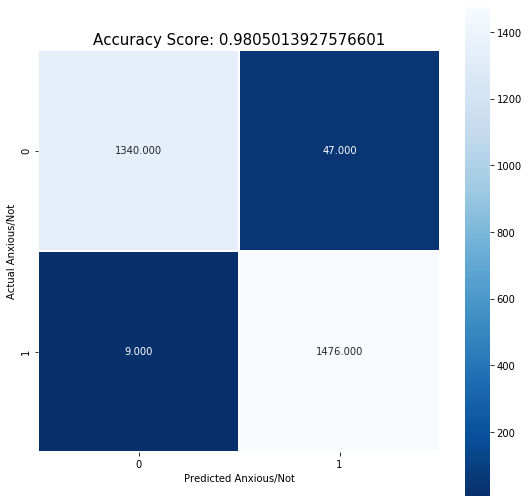

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, pred_y)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Anxious/Not');
plt.xlabel('Predicted Anxious/Not');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

F1 = 0.981  |  Auc = 0.997


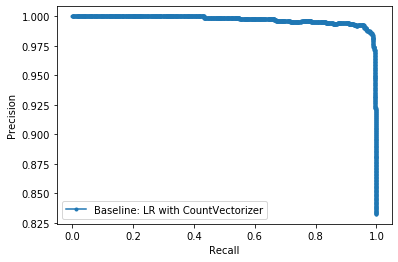

In [269]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = final_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, pred_y), auc(lr_recall, lr_precision)

# summarize scores
print('F1 = %.3f  |  Auc = %.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves

pyplot.plot(lr_recall, lr_precision, marker='.', label='Baseline: LR with CountVectorizer')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

## Run Baseline 2
Baseline 2: 
    Logistic Regression: Only one feature - CountVectorizer of the text
  
#### Note: Between ANXIOUS USERS (NEUTRAL POSTS) and CONTROL USERS (NEUTRAL POSTS) - gets harder

#### Split into Train-Test

In [280]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import featurization
importlib.reload(featurization)
from featurization import *

In [286]:
features_list = ['text']
# features_list = ['num_u', 'num_c', 'age', 'gender', \
#                  'NEG_E', 'NEG_A', 'POS_R', 'NEG_M', 'NEG_R', \
#                  'NEG_P', 'POS_M', 'POS_A', 'POS_E']

df_data = pd.concat([df_anx_3, df_control_group])
df_data = df_data.sample(frac=1) 

X = list(df_data['text'])
y = list(df_data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

In [288]:
X_train_clean = apply_cleaning_function_to_series(X_train)
X_test_clean = apply_cleaning_function_to_series(X_test)

Cleaning data
Cleaning finished
Cleaning data


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [290]:
cv = CountVectorizer(binary=True)
cv.fit(X_train_clean)
X = cv.transform(X_train_clean)
X_test = cv.transform(X_test_clean)


for c in [0.01, 0.05, 0.25, 0.5, 1]: # to choose C (Inverse regularization parameter)
    
    lr = LogisticRegression(C=c, max_iter=5000)
    lr.fit(X, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.8575905292479109
Accuracy for C=0.05: 0.9028551532033426
Accuracy for C=0.25: 0.9286211699164345
Accuracy for C=0.5: 0.9321030640668524
Accuracy for C=1: 0.9341922005571031


In [291]:
final_model = LogisticRegression(C=1, max_iter = 5000)
final_model.fit(X, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [292]:
pred_y = final_model.predict(X_test)
score = final_model.score(X_test, y_test)

### Evaluation
1. Accuracy scores
2. Confusion Matrix

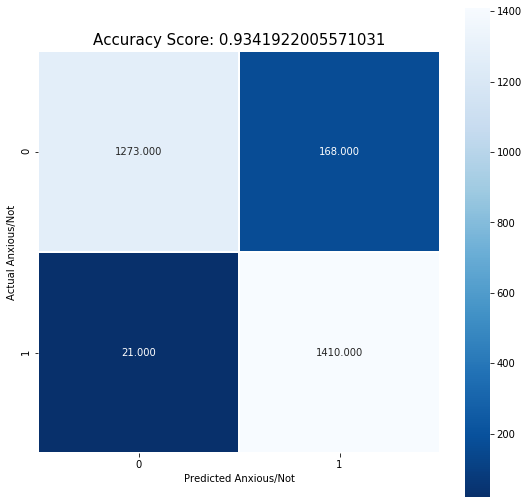

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, pred_y)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Anxious/Not');
plt.xlabel('Predicted Anxious/Not');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

F1 = 0.937  |  Auc = 0.984


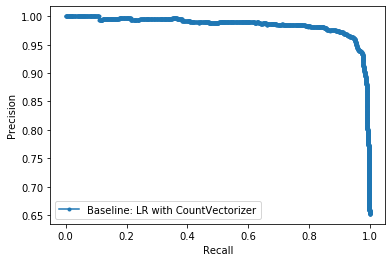

In [294]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = final_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, pred_y), auc(lr_recall, lr_precision)

# summarize scores
print('F1 = %.3f  |  Auc = %.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves

pyplot.plot(lr_recall, lr_precision, marker='.', label='Baseline: LR with CountVectorizer')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

### Run Baseline 2
Baseline 2: 
    Logistic Regression: All features + (bigrams, unigrams) of text

### Evaluation
1. Accuracy scores
2. Confusion Matrix

### Run Baseline 3
Baseline 3: 
    Logistic Regression: All features + character level ngrams of text?

### Evaluation
1. Accuracy scores
2. Confusion Matrix

### VISUALISATION
#### 1. Word Cloud based on LOG ODDS


In [189]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}


pos_words = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:100]

neg_words = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:100]


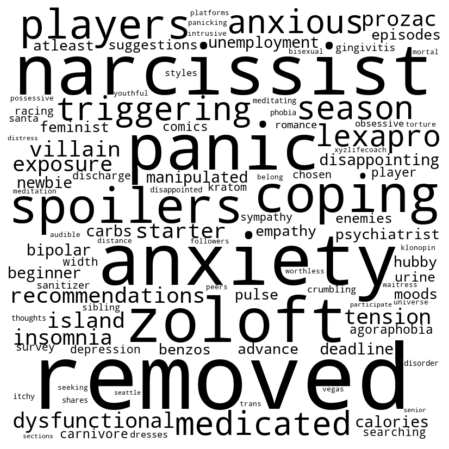

In [190]:
show_cloud(pos_words)

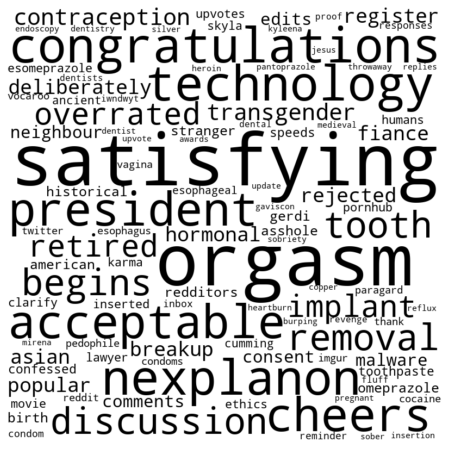

In [191]:
show_cloud(neg_words)

#### 2. Number of posts in non-anxiety forums by each group

In [192]:
anx_group = pd.read_csv("dataset/reddit-posts-unrelated.csv", index_col=0)
control_group = pd.read_csv("dataset/reddit-control.csv", index_col=0)

anx_counter = Counter()
control_counter = Counter()
for sub in anx_group['sub']:
    anx_counter[sub] += 1

for sub in control_group['sub']:
    control_counter[sub] += 1
    
print(pd.DataFrame(anx_counter.most_common(20)).head(20))

                      0     1
0             AskReddit  1196
1     NoStupidQuestions   278
2                Advice   257
3                 NoFap   225
4   relationship_advice   222
5                   aww   220
6      unpopularopinion   190
7        Showerthoughts   184
8                  cats   161
9                 trees   152
10          emetophobia   151
11             insomnia   151
12                  ibs   141
13        relationships   140
14             BreakUps   137
15                 dpdr   135
16                Drugs   133
17            teenagers   132
18                memes   130
19         Christianity   125


In [193]:
print(pd.DataFrame(control_counter.most_common(20)).head(20))

                      0    1
0                  IAmA  979
1       TalesFromRetail  951
2           legaladvice  937
3          pettyrevenge  936
4         AmItheAsshole  935
5           techsupport  933
6    CasualConversation  895
7            ProRevenge  881
8                  Vent  878
9                  rant  874
10                 GERD  867
11               Advice  864
12        dating_advice  859
13     unpopularopinion  858
14                  sex  840
15         stopdrinking  835
16        relationships  830
17         socialskills  825
18  relationship_advice  816
19                 dogs  816
